<a href="https://colab.research.google.com/github/darisoy/EE596_Project/blob/main/GAN_room_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GAN for Creating Furnished Rooms

This code implements a simple Deep Convolutional GAN for creating furnished rooms. And uses a custom dataset for training

## Setup
furnished_dataset is created

In [1]:
# import data
!git clone https://github.com/darisoy/EE596_Project.git

Cloning into 'EE596_Project'...
remote: Enumerating objects: 3926, done.
remote: Counting objects: 100% (3926/3926), done.
remote: Compressing objects: 100% (3918/3918), done.
remote: Total 3926 (delta 26), reused 3878 (delta 6), pack-reused 0
Receiving objects: 100% (3926/3926), 60.81 MiB | 36.22 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [129]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch import nn
from torch.nn import init
import torch.optim as optim
import torchvision.utils as vutils

In [182]:
# Define Image Transformation
im_size = 100
transform = transforms.Compose([transforms.Resize((im_size, im_size)),
                                 transforms.ToTensor()]) 
full_dataset = datasets.ImageFolder('EE596_Project/data/', transform=transform)

# Get only furnished images
furnished_idxs = []
for k, data in enumerate(full_dataset.imgs):
  if data[1] == 2:
    furnished_idxs.append(k)

furnished_dataset = Subset(full_dataset, furnished_idxs)

torch.Size([3, 100, 100])

## GAN Helper Functions

In [107]:
# Helper functions
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count

def sample_noise(batch_size, dim):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """
    return torch.FloatTensor(batch_size, dim).uniform_(-1, 1)

class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)

def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

def bce_loss(input, target):
    """
    Numerically stable version of the binary cross-entropy loss function.

    As per https://github.com/pytorch/pytorch/issues/751
    See the TensorFlow docs for a derivation of this formula:
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

    Inputs:
    - input: PyTorch Tensor of shape (N, ) giving scores.
    - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

    Returns:
    - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
    """
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss described above.
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    N, _ = logits_real.size() 
    loss = (bce_loss(logits_real, torch.ones(N).type(dtype)))+(bce_loss(logits_fake, torch.zeros(N).type(dtype)))
    return loss


def generator_loss(logits_fake):
    """
    Computes the generator loss described above.
    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    N, _ = logits_fake.size()
    loss = (bce_loss(logits_fake, torch.ones(N).type(dtype)))
    return loss

def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr = 1e-3, betas = (0.5,0.999))
    return optimizer

def run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train, show_every=250, 
              batch_size=128, noise_size=96, num_epochs=10):
    """
    Train a GAN!
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in loader_train:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x.type(dtype)
            logits_real = D(2* (real_data - 0.5)).type(dtype)
            
            #g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            g_fake_seed = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).type(dtype)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images)

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_noise(batch_size, noise_size).type(dtype)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

## Define GAN

In [201]:
device='cuda'

# Batch size during training
BATCH_SIZE = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 100

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
NOISE_DIM = 100

# Size of feature maps in generator
ngf = 100

# Size of feature maps in discriminator
ndf = 100

lr = 0.0002

beta1 = 0.5

# Number of training epochs
num_epochs = 100

furnished_dataloader = DataLoader(furnished_dataset,batch_size=BATCH_SIZE)

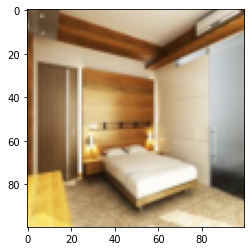

In [190]:
plt.imshow(next(enumerate(furnished_dataloader))[1][0][3,:,:,:].permute(1,2,0))

In [191]:
def build_dc_classifier(batch_size):
    """
    Build and return a PyTorch model for the DCGAN discriminator implementing
    the architecture above.
    """
    class View(nn.Module):
      def __init__(self, shape):
        super(View, self).__init__()
        self.shape = shape

      def forward(self, x):
        return x.view(*self.shape)
    
    
    model = nn.Sequential(
      nn.Conv2d(3,32,5,2),
      nn.LeakyReLU(0.01),
      nn.MaxPool2d(4,3),
      nn.Conv2d(32,64,5,1),
      nn.LeakyReLU(0.01),
      nn.MaxPool2d(2,3),
      View((batch_size,64*4*4)),
      nn.Linear(4*4*64, 4*4*64),
      nn.LeakyReLU(0.01),
      nn.Linear(4*4*64,1),
      nn.Sigmoid()
    )
    return model

data = next(enumerate(furnished_dataloader))[1][0].type(dtype)
print('Input Size:',data.size())
b = build_dc_classifier(BATCH_SIZE).type(dtype)
out = b(data)
print('Output Size and Value:', out.size(), out[0].item())

Input Size: torch.Size([128, 3, 100, 100])
Output Size and Value: torch.Size([128, 1]) 0.504209578037262


torch.Size([128, 3, 100, 100])


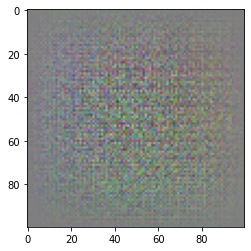

In [192]:
def build_dc_generator(noise_dim, batch_size):
  """
  Build and return a PyTorch model implementing the DCGAN generator using
  the architecture described above.
  """
  class View(nn.Module):
    def __init__(self, shape):
      super(View, self).__init__()
      self.shape = shape

    def forward(self, x):
      return x.view(*self.shape)

  model = nn.Sequential(
    # input is Z, going into a convolution
    nn.ConvTranspose2d( noise_dim, ngf * 8, 4, 1, 0, bias=False),
    nn.BatchNorm2d(ngf * 8),
    nn.ReLU(True),
    # state size. (ngf*8) x 4 x 4
    nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 4),
    nn.ReLU(True),
    # state size. (ngf*4) x 8 x 8
    nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf * 2),
    nn.ReLU(True),
    # state size. (ngf*2) x 16 x 16
    nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
    nn.BatchNorm2d(ngf),
    nn.ReLU(True),
    # state size. (ngf) x 32 x 32
    nn.ConvTranspose2d( ngf, nc, 40, 2, 1, bias=False),
    nn.Sigmoid()
    # state size. (nc) x 64 x 64
  )
  return model

test_g_gan = build_dc_generator(noise_dim=NOISE_DIM, batch_size=BATCH_SIZE).type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(BATCH_SIZE, NOISE_DIM).type(dtype)
fake_seed = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
print(fake_images.size())

plt.imshow(fake_images[0,:,:,:].cpu().detach().permute(1,2,0))

In [111]:
D_DC = build_dc_classifier(BATCH_SIZE).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator(NOISE_DIM, BATCH_SIZE).type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train=furnished_dataloader, num_epochs=5)

RuntimeError: ignored

## Using DCGAN Tutorial - Pytorch

In [193]:
netD = build_dc_classifier(BATCH_SIZE)
netD.apply(initialize_weights)
netG = build_dc_generator(NOISE_DIM, BATCH_SIZE)
netG.apply(initialize_weights)

netD.to(device)
netG.to(device)

Sequential(
  (0): ConvTranspose2d(100, 800, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(800, 400, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(400, 200, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(200, 100, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(100, 3, kernel_size=(40, 40), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Sigmoid()
)

In [194]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [202]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(furnished_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        if i == 9: continue
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, NOISE_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(furnished_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(furnished_dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/100][0/10]	Loss_D: 0.9492	Loss_G: 1.2695	D(x): 0.6671	D(G(z)): 0.4179 / 0.2810
[1/100][0/10]	Loss_D: 0.6962	Loss_G: 2.0566	D(x): 0.5551	D(G(z)): 0.0918 / 0.1280
[2/100][0/10]	Loss_D: 0.5652	Loss_G: 3.1359	D(x): 0.7881	D(G(z)): 0.2732 / 0.0436
[3/100][0/10]	Loss_D: 1.7960	Loss_G: 1.1768	D(x): 0.3246	D(G(z)): 0.4587 / 0.3106
[4/100][0/10]	Loss_D: 0.7290	Loss_G: 1.7771	D(x): 0.7345	D(G(z)): 0.3359 / 0.1692
[5/100][0/10]	Loss_D: 1.3660	Loss_G: 1.2302	D(x): 0.3072	D(G(z)): 0.0911 / 0.2924
[6/100][0/10]	Loss_D: 1.3565	Loss_G: 1.2361	D(x): 0.4523	D(G(z)): 0.3369 / 0.3002
[7/100][0/10]	Loss_D: 1.4654	Loss_G: 0.7553	D(x): 0.4340	D(G(z)): 0.4556 / 0.4699
[8/100][0/10]	Loss_D: 1.1495	Loss_G: 0.9859	D(x): 0.5056	D(G(z)): 0.3550 / 0.3731
[9/100][0/10]	Loss_D: 1.1351	Loss_G: 1.2488	D(x): 0.5141	D(G(z)): 0.3525 / 0.2869
[10/100][0/10]	Loss_D: 1.0246	Loss_G: 1.2940	D(x): 0.5887	D(G(z)): 0.3748 / 0.2743
[11/100][0/10]	Loss_D: 1.5537	Loss_G: 0.9238	D(x): 0.3302	D(G(z)): 0.25

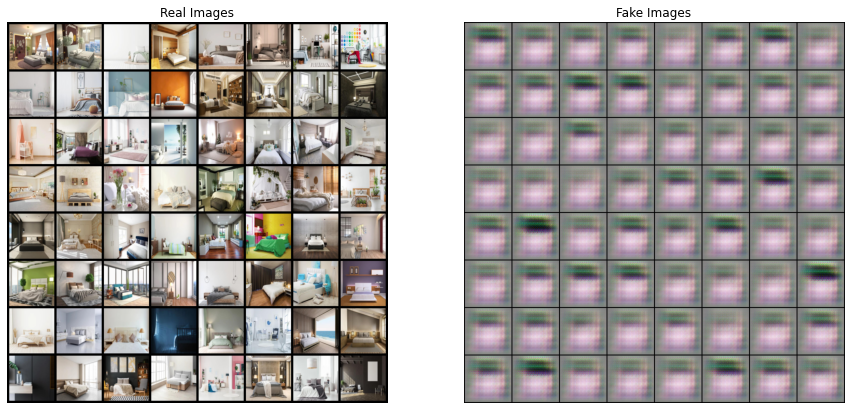

In [203]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(furnished_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [147]:
output = netD(real_cpu).view(-1)
print(output.size(), label.size

torch.Size([128]) torch.Size([128])


## Archive

In [131]:
data = next(enumerate(furnished_dataloader))

In [133]:
data[1]

[tensor([[[[0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353],
           [0.8314, 0.8314, 0.8314,  ..., 0.8314, 0.8314, 0.8314],
           [0.8275, 0.8275, 0.8275,  ..., 0.8275, 0.8275, 0.8275],
           ...,
           [0.8235, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.8235],
           [0.8235, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.8235],
           [0.8235, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.8235]],
 
          [[0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353],
           [0.8314, 0.8314, 0.8314,  ..., 0.8314, 0.8314, 0.8314],
           [0.8275, 0.8275, 0.8275,  ..., 0.8275, 0.8275, 0.8275],
           ...,
           [0.8235, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.8235],
           [0.8235, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.8235],
           [0.8235, 0.8235, 0.8235,  ..., 0.8235, 0.8235, 0.8235]],
 
          [[0.8353, 0.8353, 0.8353,  ..., 0.8353, 0.8353, 0.8353],
           [0.8314, 0.8314, 0.8314,  ..., 0.8314, 0.8314, 0.8314],
           [0.8275, 0.82

In [ ]:
train_loader = torch.utils.data.DataLoader(furnished_dataset, batch_size=32, shuffle=True)

In [ ]:
for train in train_loader:
  break

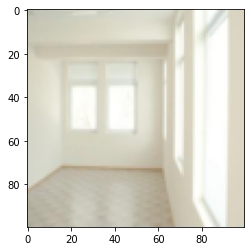

In [48]:
datac = data.cpu()
plt.imshow(datac[8].permute(1,2,0))

In [ ]:
train[1]

tensor([2, 2, 0, 0, 2, 0, 0, 2, 2, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 1, 0, 0, 2, 2,
        2, 2, 0, 0, 1, 1, 0, 1])

In [39]:
data[0].size()

torch.Size([3, 100, 100])